In [1]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import time
import re
import unidecode
from selenium.webdriver.support.ui import Select

Мы будем парсить сайт Мосбиржи, а именно внебиржевые сделки, через селениум. Почему это делаем?
Мосбиржа нигде (да, правда) не выкладывает агрегированные (месяц, год) данные по внебиржевым сделкам. Их просто 
почему-то нет. НО! Есть данные по всем внебиржевым сделкам после каждого дня по всем бумагам. Это мы и будем выкачивать) 
Меня лично будут интересовать ОФЗ (Облигации федерального займа) и корпоративные облигации. При желании этот список можно расширить и до акций обычных, привилегированных, еврооблигаций и т.д.  Но меня это не интересует. Я хочу сравнить рынки корпов и ОФЗ по объемам и понять их ликвидность

Ссылка на сайт находится ниже. 

In [2]:
url = 'https://www.moex.com/ru/expit/trades.aspx'

Одна из самых крупных проблем, с которой пришлось столкнутся - сайт очень тяжело парсится. Мосбиржа
всячески этому препятствует, и попытки автоматически проходить по каждому дню будут немного тщетны, потому что почему-то сайт не воспринимает цифры 1,2,3,11,22. Почему так - я не знаю, очень долго пытался решить эту проблему автоматически, но не вышло. Из-за этого каждый месяц требует корректировки вручную

In [51]:
driver = webdriver.Chrome('/Users/freezylex/Desktop/chromedriver')

In [52]:
driver.get(url)

In [53]:
driver.find_element_by_xpath('//*[@id="content_disclaimer"]/div/div/div/div[1]/div/a[1]').click() # принимаем согласие, что нам больше 
# 18 лет и т.д., которое высвечивается сначала)

In [221]:
cols = ['Дата',
        'Объем сделок по корпоративным облигациям',
        'Среднее количество сделок по одной корпоративной облигации',
        'Количество сделок по корпоративным облигациям',
        'Объем сделок по ОФЗ',
        'Среднее количество сделок по одной ОФЗшке',
        'Количество сделок по ОФЗ']

In [222]:
my_data = pd.DataFrame(columns = cols) #пустой датафрейм

In [182]:
def making_it_right(PdDf):
    try:
        df = PdDf[10] #обычная табличка
        five_percent = PdDf[8] #табличка с больше чем 5% сделок по эмитенту
        global my_data

        def correct(string): #Для дальнейшей обработки упрощаю названия, а также таким образом потом
            #выделятся только нужные мне
            if re.search('Облигация биржевая', string) != None:
                return 'Корпоративная облигация'
            if re.search('Облигация корпоративная', string) != None:
                return 'Корпоративная облигация'
            if re.search('Облигация федерального займа', string) != None:
                return 'ОФЗ'

        def correct_sum(string): #обрабатываем цифры объемов
            string = unidecode.unidecode(string).strip().replace(' ','')
            try:
                string = string.replace(',','.')
                string = float(string)
            except:
                string = float(string)
            return string


        df['Тип облигации'] = df['Наименование эмитента, вид ц/б'].apply(correct)
        df.dropna(subset=['Тип облигации'], inplace=True)
        if len(five_percent.columns) > 1: #может быть такое, что там есть две таблички - 
            # меньше 5 процентов эмитента и больше. Вот тут как раз обрабатываем этот случай
            five_percent['Тип облигации'] = five_percent['Наименование эмитента, вид ц/б'].apply(correct)
            five_percent.dropna(subset=['Тип облигации'], inplace=True)
        date = df['Датаотчетасделок'].iloc[0] #дата
        types = ['Корпоративная облигация', 'ОФЗ']
        dictionary = {}
        dictionary['Дата'] = date
        for i in types:
            '''
            Тут я создаю словарь, в котором у меня ключом будут информация по типу облигация, а значением - собственно,
            сами цифры
            '''
            data_temp = df[df['Тип облигации'] == i]
            summ = data_temp['Объемсделок,руб.'].apply(correct_sum).sum()
            sred_sdelok = (data_temp['Кол-восделок'].sum()/len(data_temp['Кол-восделок']))
            kol_vo = len(data_temp['Кол-восделок'])
            if len(five_percent.columns) > 1: #опять-таки случай с эмитентом
                data_2 = five_percent[five_percent['Тип облигации'] == i]
                sum_2 = data_2['Объемсделок,руб.'].apply(correct_sum).sum()
                if sum_2 != None:
                    summ += sum_2
                sred_2 = (data_2['Кол-восделок'].sum()/len(data_2['Кол-восделок']))
                if sred_2 != None:
                    sred_sdelok += sred_2
                kolv_2 = len(data_2['Кол-восделок'])
                if kolv_2 != None:
                    kol_vo += kolv_2
            if i == 'Корпоративная облигация':
                dictionary['Объем сделок по корпоративным облигациям'] = [summ]
                dictionary['Среднее количество сделок по одной корпоративной облигации'] = [sred_sdelok]
                dictionary['Количество сделок по корпоративным облигациям'] = [kol_vo]
            if i == 'ОФЗ':
                dictionary['Объем сделок по ОФЗ'] = [summ]
                dictionary['Среднее количество сделок по одной ОФЗшке'] = [sred_sdelok]
                dictionary['Количество сделок по ОФЗ'] = [kol_vo]
        print((dictionary))
        my_data = my_data.append(pd.DataFrame(dictionary), ignore_index=True)
    except:
        pass

In [224]:
def rolling_over():
    for jj in range(1, 32, 1): #а так мы будем отправлять запросы, чтобы он менял нам автоматически дни.
        # почему-то, еще раз, сайт не воспринимает цифры 1,2,3,11,22. Не знаю почему...
        try:
            print(jj)
            jj = str(jj)
            driver.find_element_by_id('day1day').send_keys(jj)
            time.sleep(1)
            driver.find_element_by_xpath('/html/body/div[2]/div[3]/div/div/div[1]/div/div/div/div/form/table/tbody/tr[2]/td/table/tbody/tr[2]/td[2]/input').click()
            time.sleep(6)
            html = driver.page_source
            making_it_right(pd.read_html(html))
            time.sleep(4)
        except:
            print('Кряк')


In [225]:
rolling_over()

18
{'Дата': '18.12.2019', 'Объем сделок по корпоративным облигациям': [102943483.78], 'Среднее количество сделок по одной корпоративной облигации': [2.0714285714285716], 'Количество сделок по корпоративным облигациям': [42], 'Объем сделок по ОФЗ': [28198364128.019997], 'Среднее количество сделок по одной ОФЗшке': [2.5], 'Количество сделок по ОФЗ': [32]}
19


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


{'Дата': '19.12.2019', 'Объем сделок по корпоративным облигациям': [1595521429.0], 'Среднее количество сделок по одной корпоративной облигации': [3.1724137931034484], 'Количество сделок по корпоративным облигациям': [30], 'Объем сделок по ОФЗ': [14333636167.060001], 'Среднее количество сделок по одной ОФЗшке': [nan], 'Количество сделок по ОФЗ': [35]}
20
{'Дата': '20.12.2019', 'Объем сделок по корпоративным облигациям': [9942569.89], 'Среднее количество сделок по одной корпоративной облигации': [4.333333333333334], 'Количество сделок по корпоративным облигациям': [25], 'Объем сделок по ОФЗ': [7364956625.4800005], 'Среднее количество сделок по одной ОФЗшке': [nan], 'Количество сделок по ОФЗ': [27]}
21
{'Дата': '21.12.2019', 'Объем сделок по корпоративным облигациям': [163493.69999999998], 'Среднее количество сделок по одной корпоративной облигации': [3.5555555555555554], 'Количество сделок по корпоративным облигациям': [9], 'Объем сделок по ОФЗ': [1198023.8], 'Среднее количество сделок п

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


{'Дата': '28.12.2019', 'Объем сделок по корпоративным облигациям': [467896.5], 'Среднее количество сделок по одной корпоративной облигации': [1.6666666666666667], 'Количество сделок по корпоративным облигациям': [6], 'Объем сделок по ОФЗ': [0], 'Среднее количество сделок по одной ОФЗшке': [nan], 'Количество сделок по ОФЗ': [0]}
29
{'Дата': '29.12.2019', 'Объем сделок по корпоративным облигациям': [882420.1], 'Среднее количество сделок по одной корпоративной облигации': [2.0], 'Количество сделок по корпоративным облигациям': [6], 'Объем сделок по ОФЗ': [0], 'Среднее количество сделок по одной ОФЗшке': [nan], 'Количество сделок по ОФЗ': [0]}
30
{'Дата': '30.12.2019', 'Объем сделок по корпоративным облигациям': [5768051066.1], 'Среднее количество сделок по одной корпоративной облигации': [3.3333333333333335], 'Количество сделок по корпоративным облигациям': [31], 'Объем сделок по ОФЗ': [2455988562.3599997], 'Среднее количество сделок по одной ОФЗшке': [nan], 'Количество сделок по ОФЗ': [2

In [226]:
my_data

,Дата,Объем сделок по корпоративным облигациям,Среднее количество сделок по одной корпоративной облигации,Количество сделок по корпоративным облигациям,Объем сделок по ОФЗ,Среднее количество сделок по одной ОФЗшке,Количество сделок по ОФЗ
0,10.12.2019,1.079891e+08,3.681818,22,9.541175e+09,2.793103,29
1,20.12.2019,9.942570e+06,4.333333,25,7.364957e+09,NaN,27
2,30.12.2019,5.768051e+09,3.333333,31,2.455989e+09,NaN,21
3,04.12.2019,3.360126e+09,3.600000,46,1.505526e+10,NaN,42
4,05.12.2019,3.158123e+07,3.735294,34,6.189087e+09,2.033333,30
5,06.12.2019,8.960552e+08,4.476190,22,7.123678e+09,NaN,33
6,07.12.2019,5.606553e+05,4.300000,10,2.031420e+04,2.666667,3
7,08.12.2019,1.220977e+06,3.090909,11,2.250710e+04,2.000000,2
8,09.12.2019,5.841926e+08,3.967742,32,6.249998e+09,NaN,31
9,10.12.2019,1.079891e+08,3.681818,22,9.541175e+09,2.793103,29


In [231]:
making_it_right(pd.read_html(driver.page_source)) #это сделано чтобы подправить датасет
my_data

{'Дата': '22.12.2019', 'Объем сделок по корпоративным облигациям': [75932.1], 'Среднее количество сделок по одной корпоративной облигации': [8.0], 'Количество сделок по корпоративным облигациям': [3], 'Объем сделок по ОФЗ': [58439.1], 'Среднее количество сделок по одной ОФЗшке': [3.25], 'Количество сделок по ОФЗ': [4]}


,Дата,Объем сделок по корпоративным облигациям,Среднее количество сделок по одной корпоративной облигации,Количество сделок по корпоративным облигациям,Объем сделок по ОФЗ,Среднее количество сделок по одной ОФЗшке,Количество сделок по ОФЗ
0,10.12.2019,1.079891e+08,3.681818,22,9.541175e+09,2.793103,29
1,20.12.2019,9.942570e+06,4.333333,25,7.364957e+09,NaN,27
2,30.12.2019,5.768051e+09,3.333333,31,2.455989e+09,NaN,21
3,04.12.2019,3.360126e+09,3.600000,46,1.505526e+10,NaN,42
4,05.12.2019,3.158123e+07,3.735294,34,6.189087e+09,2.033333,30
5,06.12.2019,8.960552e+08,4.476190,22,7.123678e+09,NaN,33
6,07.12.2019,5.606553e+05,4.300000,10,2.031420e+04,2.666667,3
7,08.12.2019,1.220977e+06,3.090909,11,2.250710e+04,2.000000,2
8,09.12.2019,5.841926e+08,3.967742,32,6.249998e+09,NaN,31
9,10.12.2019,1.079891e+08,3.681818,22,9.541175e+09,2.793103,29


In [232]:
print('Корпоративные облигации: {} миллардов'.format(round(my_data['Объем сделок по корпоративным облигациям'].sum()/1000000000),2))
print('ОФЗ: {} миллиардов'.format(round(my_data['Объем сделок по ОФЗ'].sum()/1000000000),2))

Корпоративные облигации: 33.0 миллардов
ОФЗ: 222.0 миллиардов


In [233]:
my_data.drop([0,1,2,10,21], inplace=True) #дропаем повторяющееся

In [234]:
#my_data.to_csv('December_2019.csv') #сохраняем в csv

Собственно, и так для каждого месяца. Как уже было сказано, сайт действительно тяжело парсится, 
поэтому приходится все вручную корректировать

# Часть 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
months = ['January',
         'February',
         'March',
         'April',
         'May',
         'June',
         'July',
         'August',
         'September',
         'October',
         'November',
         'December']
cols = ['Месяц',
        'Объем торгов по ОФЗ',
        'Объем торгов по корпоративным облигациям',
        'Среднее количество сделок по офз',
        'Среднее количество сделок по корпоративным облигациям']
my_data = pd.DataFrame(columns = cols)

In [13]:
for i in months: # а теперь подгружаем каждый месяц и считаем агрегированную статистику!
    dictionary = {}
    string = i + '_2019.csv'
    path = '/Users/freezylex/Documents/' + string
    month_data = pd.read_csv(path)
    volume_ofz = month_data['Объем сделок по ОФЗ'].sum() #суммируем все сделки
    volume_corp = month_data['Объем сделок по корпоративным облигациям'].sum() #суммируем все сделки
    count_ofz_mean = month_data['Количество сделок по ОФЗ'].mean() #создаем новый признак - среднее количество сделок в день за месяц
    count_corp_mean = month_data['Количество сделок по корпоративным облигациям'].mean() #создаем новый признак - среднее количество сделок в день за месяц
    dictionary['Месяц'] = i
    dictionary['Объем торгов по ОФЗ'] = [volume_ofz]
    dictionary['Объем торгов по корпоративным облигациям'] = [volume_corp]
    dictionary['Среднее количество сделок по офз'] = [count_ofz_mean]
    dictionary['Среднее количество сделок по корпоративным облигациям'] = [count_corp_mean]
    my_data = my_data.append(pd.DataFrame(dictionary), ignore_index=True)

In [14]:
my_data = my_data.set_index('Месяц')
my_data

,Объем торгов по ОФЗ,Объем торгов по корпоративным облигациям,Среднее количество сделок по офз,Среднее количество сделок по корпоративным облигациям
Месяц,,,,
January,1.879148e+11,6.080216e+10,14.300000,11.533333
February,3.066814e+11,1.231952e+11,17.703704,19.851852
March,3.025438e+11,2.808618e+11,17.225806,15.516129
April,3.109719e+11,2.025978e+11,18.333333,17.633333
May,4.332400e+11,1.111143e+10,18.258065,16.645161
June,3.562842e+11,2.412917e+10,18.966667,17.000000
July,2.853447e+11,6.256234e+09,19.451613,15.451613
August,3.750406e+11,1.093433e+10,20.741935,15.451613
September,2.878821e+11,2.313030e+10,19.666667,17.666667


Как видно, теперь мы имеем информацию по каждому месяцу для корпоративных облигаций и ОФЗ. Знаем объемы торгов, а также среднее количество сделок в день в каждом месяце. Все колонки имеют данные, поэтому выбрасывать их не будем.

In [16]:
counts = my_data[['Среднее количество сделок по офз', 'Среднее количество сделок по корпоративным облигациям']]
counts #cреднее по сделкам

,Среднее количество сделок по офз,Среднее количество сделок по корпоративным облигациям
Месяц,,
January,14.300000,11.533333
February,17.703704,19.851852
March,17.225806,15.516129
April,18.333333,17.633333
May,18.258065,16.645161
June,18.966667,17.000000
July,19.451613,15.451613
August,20.741935,15.451613
September,19.666667,17.666667


In [17]:
volumes = my_data[['Объем торгов по ОФЗ','Объем торгов по корпоративным облигациям']]
volumes #объемы

,Объем торгов по ОФЗ,Объем торгов по корпоративным облигациям
Месяц,,
January,1.879148e+11,6.080216e+10
February,3.066814e+11,1.231952e+11
March,3.025438e+11,2.808618e+11
April,3.109719e+11,2.025978e+11
May,4.332400e+11,1.111143e+10
June,3.562842e+11,2.412917e+10
July,2.853447e+11,6.256234e+09
August,3.750406e+11,1.093433e+10
September,2.878821e+11,2.313030e+10


In [18]:
plt.style.use('bmh')

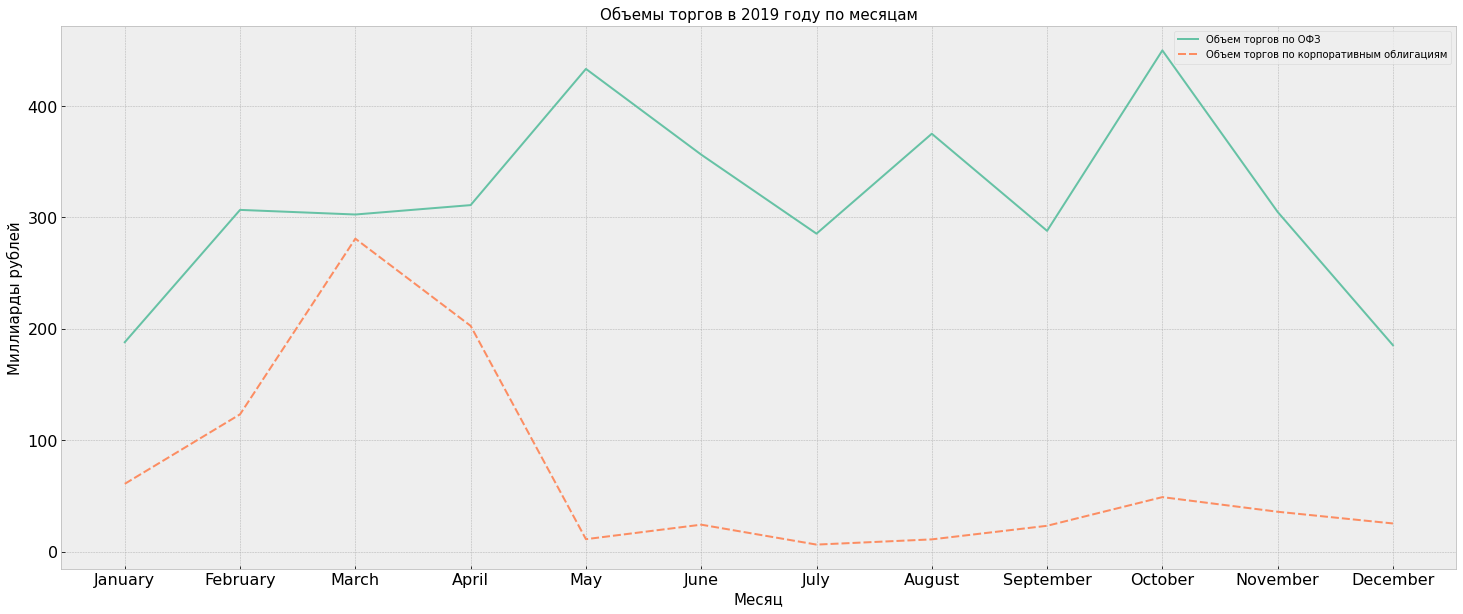

In [19]:
fig, ax = plt.subplots(figsize=(25,10))
size_t = 16
size_lab = 15
ax = sns.lineplot(
           data = volumes/1000000000,
           palette = 'Set2',
            sort = False)
ax.tick_params(axis="x", labelsize=size_t)
ax.tick_params(axis="y", labelsize=size_t)
ax.set_xlabel('Месяц', fontsize = size_lab)
ax.set_ylabel('Миллиарды рублей', fontsize = size_lab)
ax.set_title('Объемы торгов в 2019 году по месяцам', fontsize = size_lab)
plt.show()

Что мы видим? А оказывается объемы по корпам очень низкие практически всегда. Самое веселое - то, что вы видите в 
первые 4 месяца - облигации Роснефти :) Там проходили торги по объемам больше 5% от выпуска, и Роснефть сделала все 
объемы :) Оказывается, наш рынок очень неликвиден 

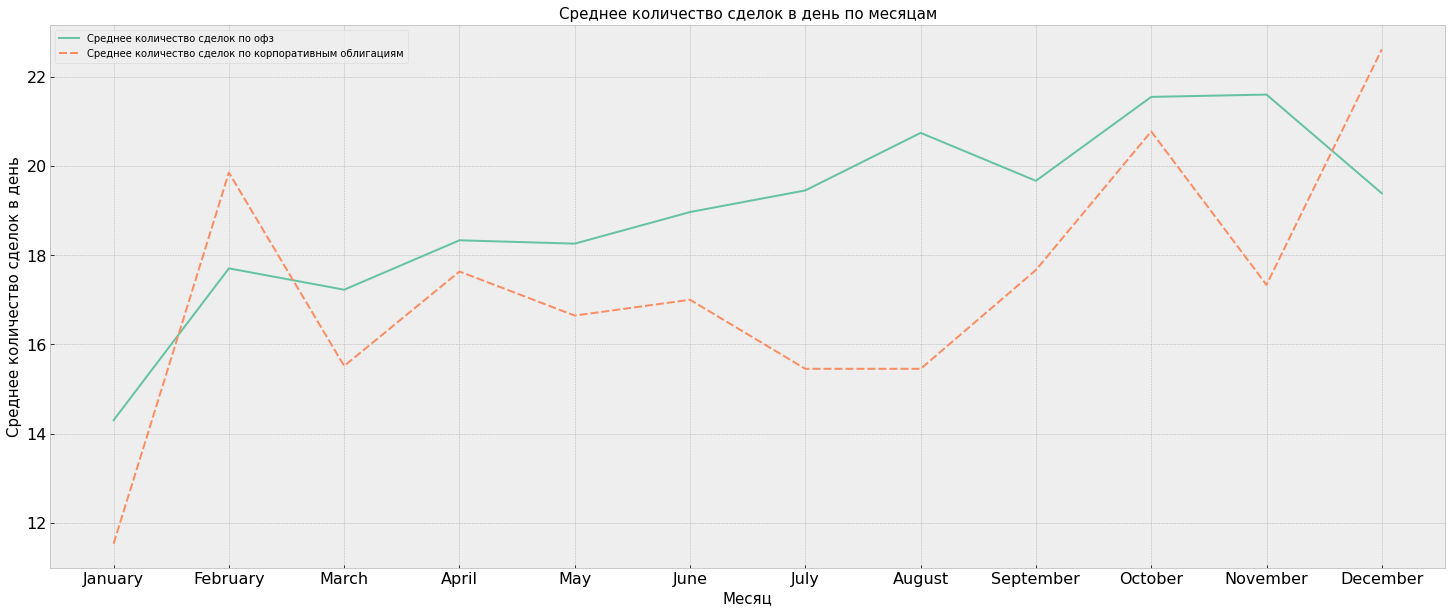

In [20]:
fig, ax = plt.subplots(figsize=(25,10))
size_t = 16
size_lab = 15
ax = sns.lineplot(
           data = counts,
           palette = 'Set2',
            sort = False)
ax.tick_params(axis="x", labelsize=size_t)
ax.tick_params(axis="y", labelsize=size_t)
ax.set_xlabel('Месяц', fontsize = size_lab)
ax.set_ylabel('Среднее количество сделок в день', fontsize = size_lab)
ax.set_title('Среднее количество сделок в день по месяцам', fontsize = size_lab)
plt.show()

При этом, среднее количество сделок примерно одинаковое. Это говорит о том, что в среднем сделка
по корпам имеет гораздо ниже объем, а значит, если вы купите большие объемы облигаций НЕ Роснефти, потом
может быть тяжело избавиться

### Спасибо за внимание!